In [1]:
import os 
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

2024-04-25 11:31:02.585852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 11:31:07.022376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
p = Path("./Data")

dirs = p.glob("*")

image_data = []
labels = []

# optionals
image_paths = []

labels_dict={"Pikachu":0,"Bulbasaur":1,"Meowth":2 }
label2pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Meowth"}

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1]
    # print(labels)
    cnt = 0
    print(folder_dir)

    # Iterate over folder_dir and pick all images of the pokemon
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(40,40))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])
        cnt += 1
    print(cnt)

Data/Pikachu
199
Data/Meowth
70
Data/Bulbasaur
171


In [3]:
p = Path("./Data/")

dirs = p.glob("*")

for folder_dir in dirs:
    # print(folder_dir)
    print(str(folder_dir).split("/")[-1])
    

Pikachu
Meowth
Bulbasaur


In [4]:
print(len(image_data))
print(len(labels))

440
440


In [5]:
import random
random.seed(10)

In [6]:
X = np.array(image_data)
Y = np.array(labels)

from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state=2)

#Normalisation
X = X/255.0

print(X.shape)
print(Y.shape)

(440, 40, 40, 3)
(440,)


In [7]:
# Draw some pokemons
def drawImg(img,label):
    plt.title(label2pokemon[label])
    plt.imshow(img)
    plt.show()

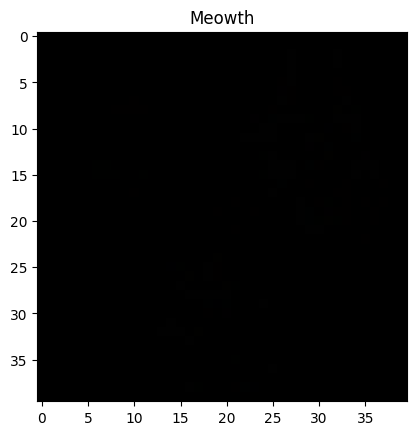

In [8]:
drawImg(X[0]/255.0,Y[0])

In [9]:
# for i in range(10):
#     r = np.random.randint(200)
#     drawImg(X[r]/255.0,Y[r])

In [10]:
# Creating Training and Test Data
split = int(X.shape[0]*.8)

X_ = np.array(X)
Y_ = np.array(Y)

# Training Set
X = X_[:split,:]
Y = Y_[:split]

#Test Set
XTest = X_[split:,:]
YTest = Y_[split:]

print(X.shape,Y.shape)
print(XTest.shape,YTest.shape)

(352, 40, 40, 3) (352,)
(88, 40, 40, 3) (88,)


In [11]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {} #Dictionary
        
        #First Layer
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        #Second Layer
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        #Third/Output Layer
        model['W3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1,output_size))
        
        self.model = model
        self.activation_outputs = None
    
    def forward(self,x):
        
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1) 
        
        z2 = np.dot(a1,W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,W3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self,x,y,learning_rate=0.001):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]
        
        a1,a2,y_ = self.activation_outputs
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(X.T,delta1)
        db1 = np.sum(delta1,axis=0)
        
        
        #Update the Model Parameters using Gradient Descent
        self.model["W1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["W2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["W3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3
        
        # :)
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)
    
    def summary(self):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)
        
        print("W2 ",W2.shape)
        print("A2 ",a2.shape)
        
        print("W3 ",W3.shape)
        print("Y_ ",y_.shape)
        
def softmax(a):
    e_pa = np.exp(a) #Vector
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans   
    

In [12]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y,depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht
    

In [13]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = len(np.unique(Y))
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        training_loss.append(l)
        model.backward(X,Y_OHT,learning_rate)
        
        if(logs):
            print("Epoch %d Loss %.4f"%(ix,l))
            
    
    return training_loss

In [14]:
model = NeuralNetwork(input_size=4800,layers=[100,50],output_size=3) # 30000 features

In [15]:
print(X.shape)

(352, 40, 40, 3)


In [16]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(352, 4800)
(88, 4800)


In [17]:
l = train(X,Y,model,500,0.0002)

Epoch 0 Loss 3.2269
Epoch 1 Loss 2.6297
Epoch 2 Loss 1.8065
Epoch 3 Loss 1.4948
Epoch 4 Loss 1.2931
Epoch 5 Loss 1.0922
Epoch 6 Loss 0.9416
Epoch 7 Loss 0.9616
Epoch 8 Loss 0.8762
Epoch 9 Loss 0.8582
Epoch 10 Loss 0.7999
Epoch 11 Loss 0.7761
Epoch 12 Loss 0.7186
Epoch 13 Loss 0.6897
Epoch 14 Loss 0.6534
Epoch 15 Loss 0.6259
Epoch 16 Loss 0.6497
Epoch 17 Loss 0.5950
Epoch 18 Loss 0.5624
Epoch 19 Loss 0.5521
Epoch 20 Loss 0.5288
Epoch 21 Loss 0.5440
Epoch 22 Loss 0.5143
Epoch 23 Loss 0.5091
Epoch 24 Loss 0.4907
Epoch 25 Loss 0.4660
Epoch 26 Loss 0.4678
Epoch 27 Loss 0.4405
Epoch 28 Loss 0.4301
Epoch 29 Loss 0.4066
Epoch 30 Loss 0.4159
Epoch 31 Loss 0.4330
Epoch 32 Loss 0.3846
Epoch 33 Loss 0.3996
Epoch 34 Loss 0.3829
Epoch 35 Loss 0.3799
Epoch 36 Loss 0.3629
Epoch 37 Loss 0.3648
Epoch 38 Loss 0.3492
Epoch 39 Loss 0.3414
Epoch 40 Loss 0.3529
Epoch 41 Loss 0.3490
Epoch 42 Loss 0.3256
Epoch 43 Loss 0.3199
Epoch 44 Loss 0.3104
Epoch 45 Loss 0.3141
Epoch 46 Loss 0.3099
Epoch 47 Loss 0.2812
Ep

KeyboardInterrupt: 

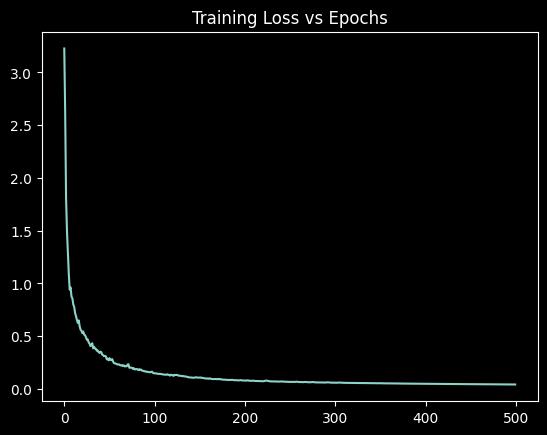

In [ ]:
plt.style.use("dark_background")
plt.title("Training Loss vs Epochs")
plt.plot(l)

plt.show()

In [ ]:
# Accuracy 
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc
    
print("Train Acc %.4f"%getAccuracy(X,Y,model))
print("Test Acc %.4f"%getAccuracy(XTest,YTest,model))

Train Acc 0.9631
Test Acc 0.6023


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
outputs = model.predict(X)
print(classification_report(outputs,Y))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       160
           1       0.96      0.98      0.97       139
           2       0.91      0.96      0.94        53

    accuracy                           0.96       352
   macro avg       0.95      0.96      0.96       352
weighted avg       0.96      0.96      0.96       352



In [ ]:
from visualize import plot_confusion_matrix

In [ ]:
cnf_matrix = confusion_matrix(outputs,Y)
print(cnf_matrix)

[[152   5   3]
 [  1 136   2]
 [  2   0  51]]


Confusion matrix, without normalization
[[152   5   3]
 [  1 136   2]
 [  2   0  51]]


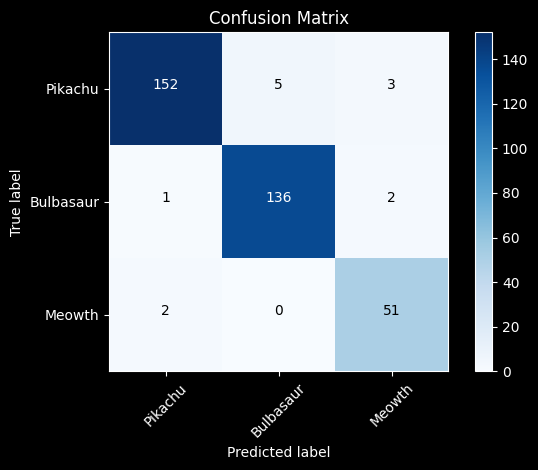

In [ ]:
plot_confusion_matrix(cnf_matrix,classes=["Pikachu","Bulbasaur","Meowth"],title="Confusion Matrix")

In [ ]:
test_outputs = model.predict(XTest)
print(classification_report(test_outputs,YTest))


              precision    recall  f1-score   support

           0       0.66      0.76      0.71        38
           1       0.67      0.61      0.63        33
           2       0.29      0.24      0.26        17

    accuracy                           0.60        88
   macro avg       0.54      0.53      0.53        88
weighted avg       0.59      0.60      0.59        88



Confusion matrix, without normalization
[[29  3  6]
 [ 9 20  4]
 [ 6  7  4]]


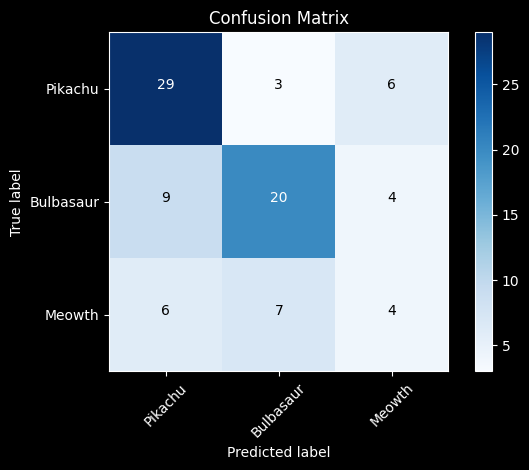

In [ ]:
cnf_matrix = confusion_matrix(test_outputs,YTest)
plot_confusion_matrix(cnf_matrix,classes=["Pikachu","Bulbasaur","Meowth"],title="Confusion Matrix")

Visualise Misclassification

Pridiction 2 Meowth


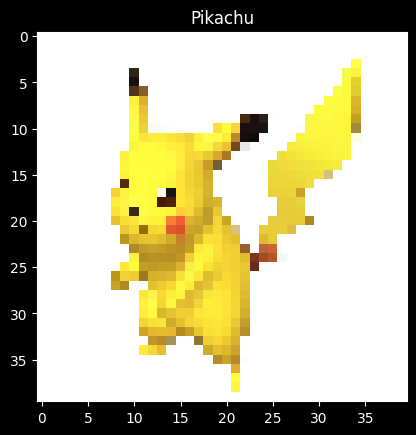

Pridiction 6 Pikachu


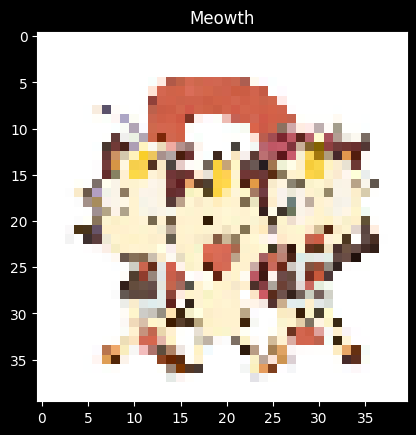

Pridiction 112 Pikachu


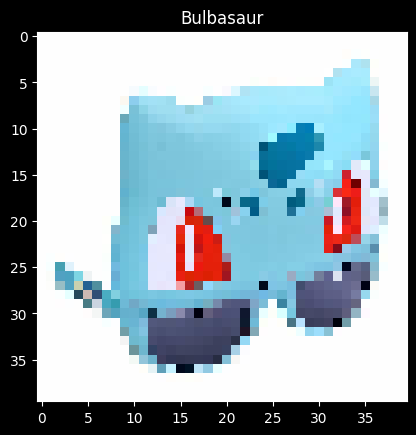

Pridiction 146 Bulbasaur


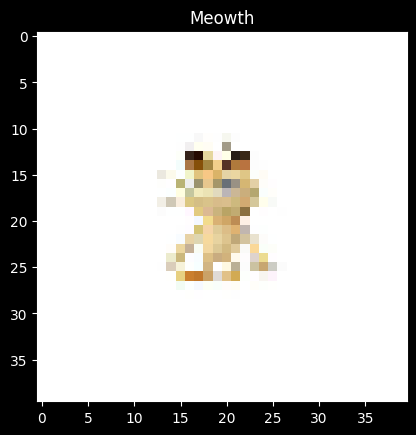

Pridiction 191 Pikachu


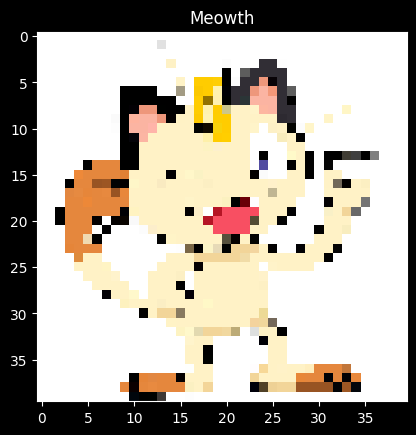

Pridiction 195 Pikachu


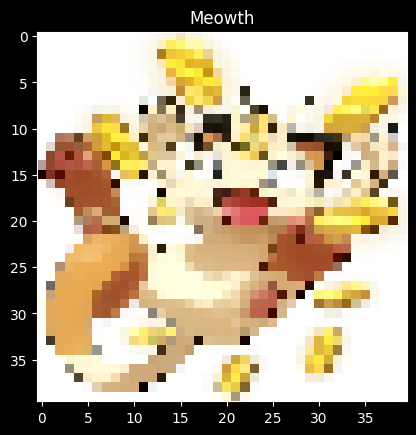

Pridiction 203 Pikachu


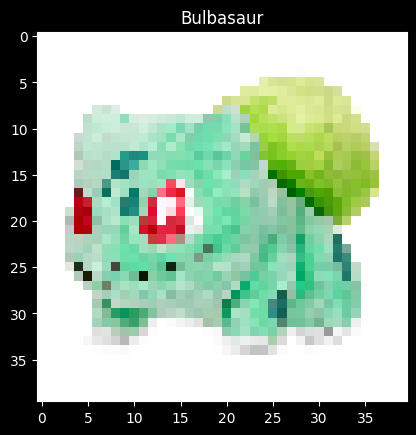

Pridiction 219 Bulbasaur


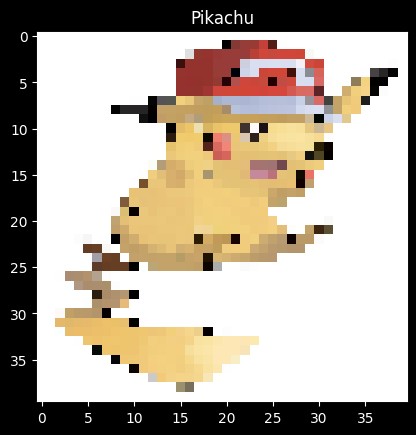

Pridiction 233 Pikachu


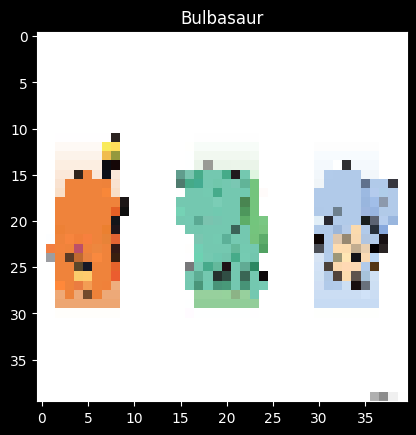

Pridiction 290 Bulbasaur


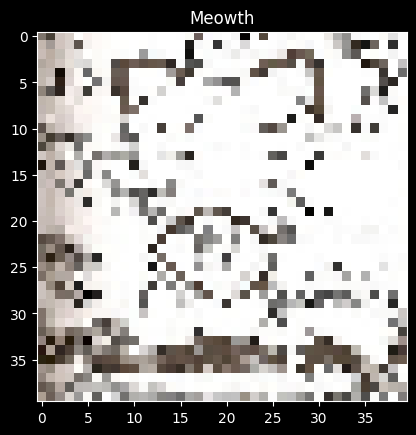

Pridiction 309 Pikachu


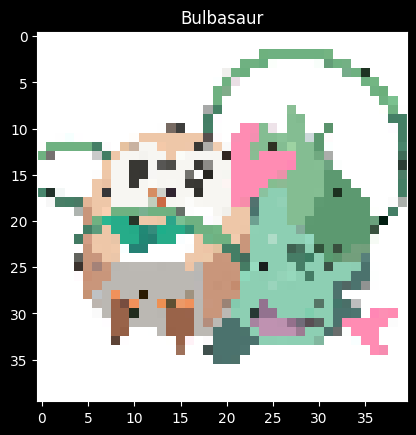

Pridiction 347 Pikachu


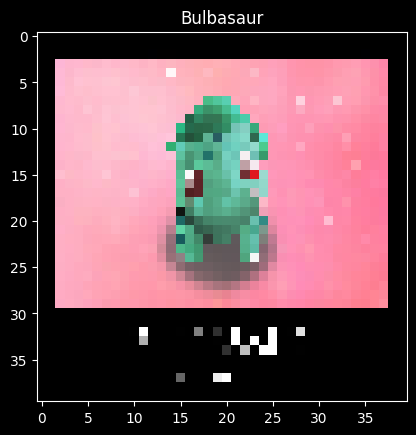

Pridiction 348 Meowth


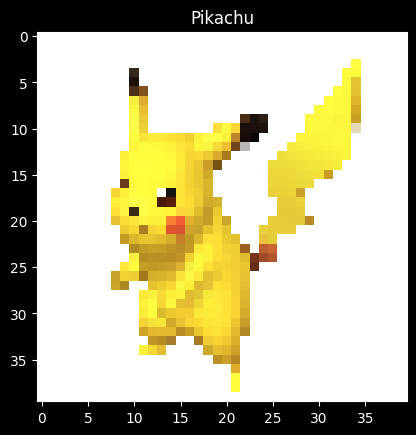

In [ ]:
for i in range(Y.shape[0]):
    if Y[i] != outputs[i]:
        print("Pridiction %d %s"%(i,label2pokemon[outputs[i]]))
        drawImg(X[i].reshape(40,40,3),Y[i])
        